# Modeling Notebook

## Library Imports

In [1]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

In [2]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [3]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")

## 1. Data Access and Structure

### 1.1 Loading Cleaned Dataset

In [4]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

# get the dataset schema
schema = scan.collect_schema()

df = scan.collect()

In [5]:
# set feature and target variables
TARGET_LABEL = 'Label'
TARGET_FAMILY = 'Label_Family'
TARGET_BINARY = 'Label_Binary'

all_columns = schema.names()
target_columns = [TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]
feature_columns = [col for col in all_columns if col not in target_columns]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col not in target_columns]



## 2. Linear Model Assumptions & Preprocessing Design

### 2.1 Multicollinearity and Redundancy

### 2.2 Scaling Strategy for Numeric Features

### 2.3 Skewness and Transformations

### 2.4 Class Balance Profiling on Target Granularities

## 3. Stratified Equal-Sized Subsampling Strategy

### 3.1 Global Subsampling Parameters

In [6]:
def get_class_counts(lazy_scan: pl.LazyFrame, target_col: str) -> pl.DataFrame:
    """
    Return a Polars DataFrame with class counts for the given target column.
    Uses lazy scan -> group_by -> aggregate -> collect.
    """
    counts = (
        lazy_scan
        .group_by(target_col)
        .agg(pl.len().alias("count"))
        .collect()
        .sort("count")
    )
    return counts

# Get class counts for Label_Family
label_family_counts = get_class_counts(scan, TARGET_FAMILY)

print("\nLabel_Family (7/8-class) counts:")
print(label_family_counts)


Label_Family (7/8-class) counts:
shape: (8, 2)
┌──────────────┬──────────┐
│ Label_Family ┆ count    │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ BRUTE_FORCE  ┆ 12520    │
│ WEB          ┆ 23707    │
│ SPOOFING     ┆ 436061   │
│ RECON        ┆ 655464   │
│ BENIGN       ┆ 1047308  │
│ MIRAI        ┆ 2359183  │
│ DOS          ┆ 4178919  │
│ DDOS         ┆ 12292078 │
└──────────────┴──────────┘


### 3.3 Subsampling for Label_Family (8 Classes)

In [7]:
# Desired per-class count
N_PER_CLASS_FAMILY = 10_000

# 1. Compute minimum available class size for safety
family_counts = (
    df.group_by(TARGET_FAMILY)
      .len()
      .rename({"len": "count"})
      .sort("count")
)

print("Label_Family class counts (ascending):")
print(family_counts)

min_family_class = family_counts["count"].min()

if N_PER_CLASS_FAMILY > min_family_class:
    print(f"\nRequested {N_PER_CLASS_FAMILY} per class, "
          f"but smallest family class has only {min_family_class}.")
    print(f"Using {min_family_class} per class instead.")
    N_PER_CLASS_FAMILY = min_family_class

print(f"\nFinal per-class sample size for Label_Family: {N_PER_CLASS_FAMILY}")

# 2. Memory-safe stratified sampling
family_subsample = (
    df
    .with_columns(
        pl.col(TARGET_FAMILY),
        pl.lit(0).alias("_dummy")
    )
    .with_columns(
        pl.col("_dummy").shuffle(seed=RANDOM_SEED).over(TARGET_FAMILY).alias("_rand")
    )
    .with_columns(
        pl.col("_rand").rank("ordinal").over(TARGET_FAMILY).alias("_rank")
    )
    .filter(pl.col("_rank") <= N_PER_CLASS_FAMILY)
    .drop(["_rand", "_rank", "_dummy"])
)

# 3. Shuffle final result so classes are mixed
family_subsample = family_subsample.sample(
    fraction=1.0,
    shuffle=True,
    seed=RANDOM_SEED
)

print("\nLabel_Family subsample shape:", family_subsample.shape)

# 4. Sanity check: each family class should have equal counts
family_subsample_counts = (
    family_subsample.group_by(TARGET_FAMILY)
                    .len()
                    .rename({"len": "count"})
                    .sort(TARGET_FAMILY)
)

family_subsample_counts

Label_Family class counts (ascending):
shape: (8, 2)
┌──────────────┬──────────┐
│ Label_Family ┆ count    │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ BRUTE_FORCE  ┆ 12520    │
│ WEB          ┆ 23707    │
│ SPOOFING     ┆ 436061   │
│ RECON        ┆ 655464   │
│ BENIGN       ┆ 1047308  │
│ MIRAI        ┆ 2359183  │
│ DOS          ┆ 4178919  │
│ DDOS         ┆ 12292078 │
└──────────────┴──────────┘

Final per-class sample size for Label_Family: 10000

Label_Family subsample shape: (80000, 42)


Label_Family,count
str,u32
"""BENIGN""",10000
"""BRUTE_FORCE""",10000
"""DDOS""",10000
"""DOS""",10000
"""MIRAI""",10000
"""RECON""",10000
"""SPOOFING""",10000
"""WEB""",10000


## 4. Train/Test Split & Preprocessing Pipelines

### 4.4 Train/Test Split & Pipeline for 'Label_Family' (8 Classes)

In [8]:
# Feature matrix (drop all target columns)
X_family = family_subsample.drop([TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]).to_pandas()

# Target vector for Label_Family
y_family = family_subsample[TARGET_FAMILY].to_pandas()

# Perform stratified train/test split
X_train_family, X_test_family, y_train_family, y_test_family = train_test_split(
    X_family,
    y_family,
    test_size=0.2,          # 80/20 split
    stratify=y_family,
    random_state=RANDOM_SEED
)

print("Label_Family train:", X_train_family.shape, "Label_Family test:", X_test_family.shape)
print("Label_Family y-train class distribution:\n", y_train_family.value_counts().sort_index())
print("Label_Family y-test class distribution:\n", y_test_family.value_counts().sort_index())

Label_Family train: (64000, 39) Label_Family test: (16000, 39)
Label_Family y-train class distribution:
 Label_Family
BENIGN         8000
BRUTE_FORCE    8000
DDOS           8000
DOS            8000
MIRAI          8000
RECON          8000
SPOOFING       8000
WEB            8000
Name: count, dtype: int64
Label_Family y-test class distribution:
 Label_Family
BENIGN         2000
BRUTE_FORCE    2000
DDOS           2000
DOS            2000
MIRAI          2000
RECON          2000
SPOOFING       2000
WEB            2000
Name: count, dtype: int64


## 5. Multiclass Logistic Regression Models

### 5.1 Model configuration and Hyperparameters

In [9]:
# Column groups (from earlier notebook sections)
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

# Numeric preprocessing: scale
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# Categorical preprocessing: one-hot encode
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### 5.3 Logistic Regression for 'Label_Family' (8 Classes)

c:\Users\graha\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression — Label_Family (7-class) ===
Accuracy:  0.6229
Precision (macro): 0.6371
Recall (macro):    0.6229
F1-score (macro):  0.6222
Saved figure to ..\Images\Logistic_Regression_Confusion_Matrix_Label_Family.png


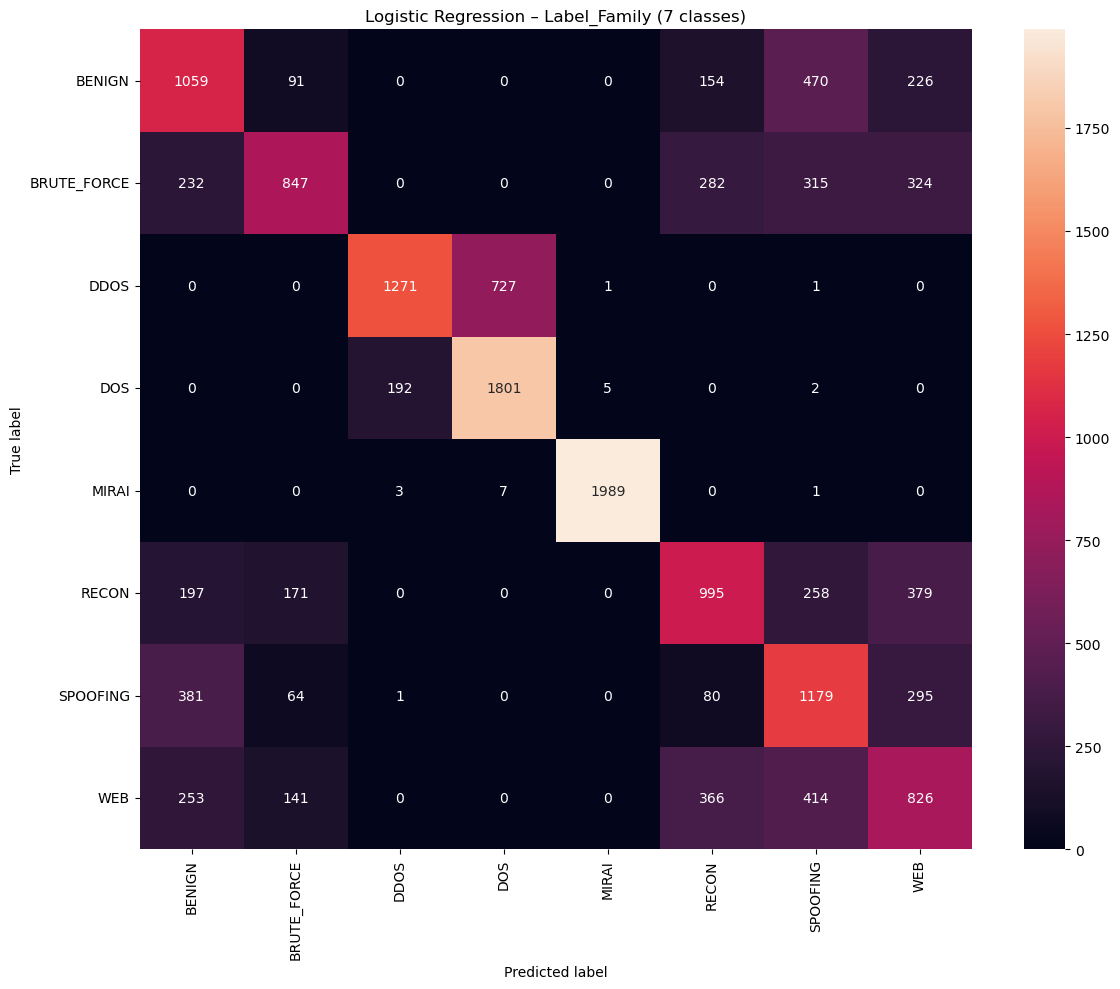

In [12]:
# Build pipeline
logreg_family_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=500,
            n_jobs=-1
        ))
    ]
)

# Fit
logreg_family_pipeline.fit(X_train_family, y_train_family)

# Predict
family_pred = logreg_family_pipeline.predict(X_test_family)

# Metrics
family_accuracy = accuracy_score(y_test_family, family_pred)
family_precision = precision_score(y_test_family, family_pred, average="macro", zero_division=0)
family_recall = recall_score(y_test_family, family_pred, average="macro", zero_division=0)
family_f1 = f1_score(y_test_family, family_pred, average="macro", zero_division=0)

print("=== Logistic Regression — Label_Family (7-class) ===")
print(f"Accuracy:  {family_accuracy:.4f}")
print(f"Precision (macro): {family_precision:.4f}")
print(f"Recall (macro):    {family_recall:.4f}")
print(f"F1-score (macro):  {family_f1:.4f}")

# Confusion Matrix
cm_family = confusion_matrix(y_test_family, family_pred, labels=logreg_family_pipeline.classes_)

# 2. Use the class labels on the axes
fig = plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_family,
    annot=True,
    fmt="d",
    xticklabels=logreg_family_pipeline.classes_,
    yticklabels=logreg_family_pipeline.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression – Label_Family (7 classes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# Save figure
save_figure(fig, "Logistic_Regression_Confusion_Matrix_Label_Family.png")
plt.show()

## 6. Linear Support Vector Machine Models

### 6.3 Linear SVM for 'Label_Family' (8 Classes)

=== Linear SVM — Label_Family (7-class) ===
Accuracy:  0.6179
Precision (macro): 0.6457
Recall (macro):    0.6179
F1-score (macro):  0.6170
Saved figure to ..\Images\Linear_SVM_Label_Family_Confusion_Matrix.png


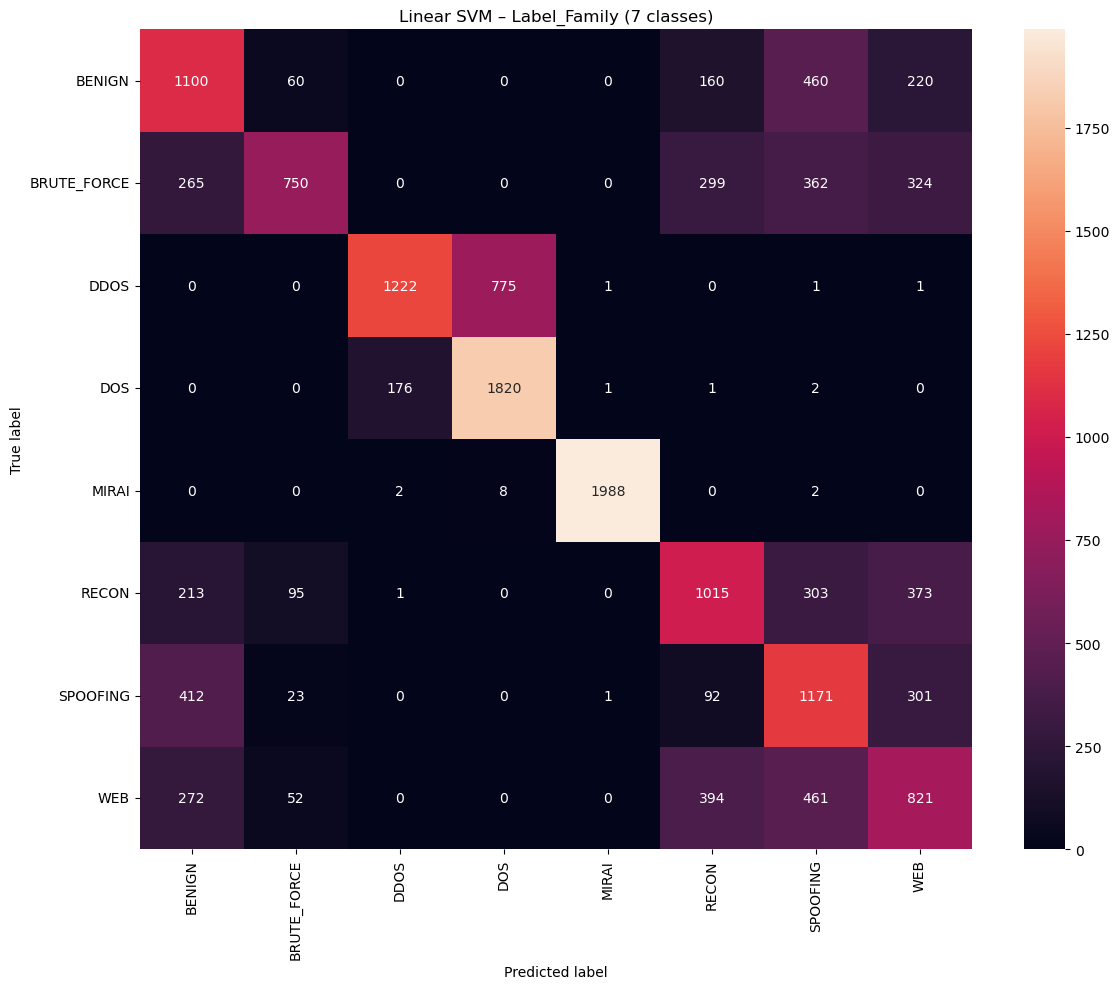

In [11]:
# Linear SVM pipeline for Label_Family
linearsvc_family_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearSVC(
            C=1.0,
            max_iter=5000,
            dual=False    # recommended for high-dimensional, more samples than features
        ))
    ]
)

# Fit
linearsvc_family_pipeline.fit(X_train_family, y_train_family)

# Predict
family_svm_pred = linearsvc_family_pipeline.predict(X_test_family)

# Metrics
family_svm_accuracy = accuracy_score(y_test_family, family_svm_pred)
family_svm_precision = precision_score(y_test_family, family_svm_pred, average="macro", zero_division=0)
family_svm_recall = recall_score(y_test_family, family_svm_pred, average="macro", zero_division=0)
family_svm_f1 = f1_score(y_test_family, family_svm_pred, average="macro", zero_division=0)

print("=== Linear SVM — Label_Family (7-class) ===")
print(f"Accuracy:  {family_svm_accuracy:.4f}")
print(f"Precision (macro): {family_svm_precision:.4f}")
print(f"Recall (macro):    {family_svm_recall:.4f}")
print(f"F1-score (macro):  {family_svm_f1:.4f}")

# Confusion Matrix
cm_family_svm = confusion_matrix(y_test_family, family_svm_pred, labels=linearsvc_family_pipeline.classes_)

# 2. Use the class labels on the axes
fig = plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_family_svm,
    annot=True,
    fmt="d",
    xticklabels=linearsvc_family_pipeline.classes_,
    yticklabels=linearsvc_family_pipeline.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Linear SVM – Label_Family (7 classes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# save figure with helper function
save_figure(fig, "Linear_SVM_Label_Family_Confusion_Matrix.png")
plt.show()

## 7. Cross Model and Cross Granularity Comparisons

### 7.1 Summary Table of Metrics

In [14]:
### 7. Results Summary Tables

# -----------------------------
# Combined Table: All Models
# -----------------------------

combined_results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Target": "Label_Family (8-class)",
        "Accuracy": family_accuracy,
        "Precision": family_precision,
        "Recall": family_recall,
        "F1": family_f1
    },
    {
        "Model": "Linear SVM",
        "Target": "Label_Family (8-class)",
        "Accuracy": family_svm_accuracy,
        "Precision": family_svm_precision,
        "Recall": family_svm_recall,
        "F1": family_svm_f1
    }
])

print("=== Combined Results Table ===")
display(combined_results)
# save table
save_table(combined_results, "Linear_Combined_Results.csv")


# -----------------------------
# Separate Table: Label_Family (8-class)
# -----------------------------

family_results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": family_accuracy,
        "Precision": family_precision,
        "Recall": family_recall,
        "F1": family_f1
    },
    {
        "Model": "Linear SVM",
        "Accuracy": family_svm_accuracy,
        "Precision": family_svm_precision,
        "Recall": family_svm_recall,
        "F1": family_svm_f1
    }
])

print("=== Label_Family (8-class) Results ===")
display(family_results)
# save table
save_table(family_results, "Linear_Label_Family_Results.csv")


=== Combined Results Table ===


,Model,Target,Accuracy,Precision,Recall,F1
0,Logistic Regression,Label_Family (8-class),0.622938,0.637139,0.622937,0.622197
1,Linear SVM,Label_Family (8-class),0.617938,0.645692,0.617938,0.616991


Saved table to ..\Tables\Linear_Combined_Results.csv
=== Label_Family (8-class) Results ===


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.622938,0.637139,0.622937,0.622197
1,Linear SVM,0.617938,0.645692,0.617938,0.616991


Saved table to ..\Tables\Linear_Label_Family_Results.csv


### 7.2 Discussion of Results